# Extract wind speed and rainfall data 

Testing functions to extract 1-minute observations of gust wind speed and rainfall amount, using the method outlined in Belcher _et al_ (2023). The data are used to estimate return periods/annual exceedance probabilities of wind speed/rainfall amount, to quantify the wind-driven rainfall probability. 

For each rainfall amount, in increments of 0.2mm, we find the maximum daily wind speed, then fit a GPD using L-moments. The same approach is then applied to each wind speed amount (using increments of 1 km/h) to find maximum daily 1-minute duration rainfall and again, fit a GPD using L-moments. 



In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import scipy.stats as stats
import scipy.optimize as opt
import lmoments3 as lm
from lmoments3 import distr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

from stndata import ONEMINUTESTNNAMES, ONEMINUTEDTYPE, ONEMINUTENAMES
variable = 'windgust'
stateTZ = 10

In [2]:
stnNum = 32040
fname = r"X:\georisk\HaRIA_B_Wind\data\raw\from_bom\2023\1-minute\HD01D_Data_033045_9999999910402064.txt"
df = pd.read_csv(fname, sep=',', index_col=False,
                dtype=ONEMINUTEDTYPE,
                names=ONEMINUTENAMES,
                header=0,
                parse_dates={'datetime': [7, 8, 9, 10, 11]},
                na_values=['####'],
                skipinitialspace=True)
for var in ['windspd', 'windmin',
            'winddir', 'windgust']:
    df.loc[~df[f"{var}q"].isin(['Y']), [var]] = np.nan
df.loc[~df['rainq'].isin(['Y']), ['rainfall']] = np.nan
df['datetime'] = pd.to_datetime(df.datetime, format="%Y %m %d %H %M")
df['datetime'] = df.datetime - timedelta(hours=stateTZ)
df['date'] = df.datetime.dt.date
df.set_index('datetime', inplace=True)
nyears = (df.date.max() - df.date.min()).days/365.25
intervals = np.array([1, 5, 10, 25, 50, 100, 500])

In [3]:
def returnLevels(intervals, loc, shp, scl, rate, npyr=365.25) -> np.array:
    rl = loc + (scl / shp) * (np.power(intervals * npyr * rate, shp) - 1.)
    return rl

In [36]:
def calculate_recurrence_levels(data, return_periods):
    """
    Calculate adjusted recurrence intervals based on a fitted generalized Pareto distribution.

    Parameters:
    - data: Numpy array containing daily maxima observations.
    - return_periods: Array of original return periods (in years).

    Returns:
    - adjusted_recurrence_intervals: Array of adjusted recurrence intervals.
    """
    print(len(data))
    # Fit the generalized Pareto distribution to the data
    params = stats.genpareto.fit(data)
    print(params)
    # Create a distribution object with the fitted parameters
    dist = stats.genpareto(*params)

    # Number of observations per year (assuming daily data)
    nopy = 365

    # Initialize an array to store adjusted recurrence intervals
    rls = []

    for rp in return_periods:
        # Adjust the return period
        arp = rp / nopy

        # Calculate the probability of exceedance
        p = 1 / (rp + 1)

        rl = dist.ppf(1-p)
        print(rp, arp, p, rl)
        # Convert the recurrence value to the adjusted recurrence interval in years
        adjusted_recurrence_interval = 1 /(p+1)
        recurrence_value = dist.ppf(adjusted_recurrence_interval)
        print(adjusted_recurrence_interval, recurrence_value)
        rls.append(rl)

    return np.array(rls)


In [37]:
calculate_recurrence_levels(df.groupby('date')[variable].max().dropna().values, intervals)

6750
(0.06604807716097999, 14.7999999999597, 24.36424256110164)
1 0.0027397260273972603 0.5 32.08054867811473
0.6666666666666666 42.56189513160599
5 0.0136986301369863 0.16666666666666666 61.142954424437114
0.8571428571428571 65.39214766423953
10 0.0273972602739726 0.09090909090909091 78.10352832500072
0.9166666666666667 80.59444654354556
25 0.0684931506849315 0.038461538461538464 103.36918133858138
0.9629629629629629 104.5108924918273
50 0.136986301369863 0.0196078431372549 124.18497842631274
0.9807692307692308 124.7987681107803
100 0.273972602739726 0.009900990099009901 146.2639880571228
0.9901960784313726 146.58968469007266
500 1.36986301369863 0.001996007984031936 202.08898668711646
0.99800796812749 202.16224042841148


array([ 32.08054868,  61.14295442,  78.10352833, 103.36918134,
       124.18497843, 146.26398806, 202.08898669])

c:\W10Dev\Anaconda3\envs\process\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='windgust', ylabel='Density'>

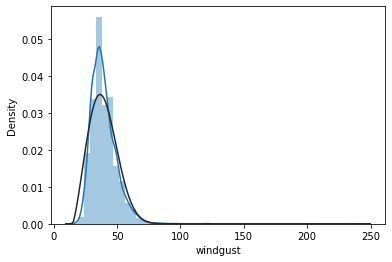

In [158]:
sns.distplot(df.groupby('date')[variable].max().dropna(), fit=stats.weibull_min)

In [4]:
def weibull_return_levels(recurrence_intervals, scale_parameter, shape_parameter, location_parameter):
    def cdf_weibull(x):
        return 1 - np.exp(-((x - location_parameter) / scale_parameter) ** shape_parameter)

    return_levels = []
    for T in recurrence_intervals:
        target_prob = 1 - 1 / T
        x_return = opt.root_scalar(lambda x: cdf_weibull(x) - target_prob, bracket=[location_parameter, location_parameter + scale_parameter * 10]).root
        return_levels.append(x_return)

    return return_levels

In [ ]:
recurrence_intervals = [2, 5, 10, 50]  # Recurrence intervals in years
scale_parameter = 100  # Replace this with your actual scale parameter value
shape_parameter = 2  # Replace this with your actual shape parameter value
location_parameter = 50
return_levels = weibull_return_levels(recurrence_intervals, scale_parameter, shape_parameter, location_parameter)
print(return_levels)

In [24]:
wsparamdf = pd.DataFrame(
    columns=['stnNum', 'rainfall', 'max_windgust', 'nobs', 'shape', 'scale', 'loc']
    )
rfparamdf = pd.DataFrame(
    columns=['stnNum', 'windgust', 'max_rainfall', 'nobs', 'shape', 'scale', 'loc']
    )

wlist = []
rlist = []

rpwlist = []  # List for windspeed return periods
rprlist = []  # List for rainfall return periods


In [29]:
for rlev in np.arange(0.2, df.rainfall.max()+0.1, 0.2):
    nobs = len(df)
    rdf = df[df.rainfall >= rlev]
    wlev = rdf.loc[rdf.groupby(['date'])[variable].idxmax().dropna()]
    wdata = np.zeros(len(df))
    wdata[0:len(wlev['windgust'].values)] = wlev['windgust'].values
    if len(wlev) < 20: break
    lmomparam = dict(distr.gpa.lmom_fit(wdata))
    wlist.append({
        'stnNum': stnNum,
        'rainfall': rlev,
        'max_windgust': wlev['windgust'].max(),
        'nobs': len(wlev),
        'shape': lmomparam['c'],
        'loc': lmomparam['loc'],
        'scale': lmomparam['scale']})
    rl = returnLevels(intervals,
                      lmomparam['loc'],
                      lmomparam['c'],
                      lmomparam['scale'],
                      len(wlev)/(nyears*365.25))
    for val, interval in zip(rl, intervals):
        rpwlist.append({
            'stnNum': stnNum,
            'rainfall': rlev,
            'RP': interval,
            'windspeed': val})
wsparamdf = pd.DataFrame(wlist)
wsrldf = pd.DataFrame(rpwlist)

In [30]:
wsparamdf

,stnNum,rainfall,max_windgust,nobs,shape,loc,scale
0,32040,0.2,244.4,2536,0.080959,-1.074938e-08,7.418754e-12
1,32040,0.4,244.4,1436,0.076042,-2.719238e-09,5.690558e-13
2,32040,0.6,218.5,745,0.070864,-5.008097e-10,2.349410e-14
3,32040,0.8,218.5,745,0.070864,-5.008097e-10,2.349410e-14
4,32040,0.2,244.4,2536,0.999620,-1.650900e-06,3.303138e-06
5,32040,0.4,244.4,1436,0.999781,-5.744445e-07,1.149156e-06
6,32040,0.6,218.5,745,0.999887,-1.555017e-07,3.110408e-07
7,32040,0.8,218.5,745,0.999887,-1.555017e-07,3.110408e-07
8,32040,1.0,218.5,575,0.999915,-8.906101e-08,1.781383e-07
9,32040,1.2,218.5,399,0.999940,-4.385805e-08,8.772171e-08


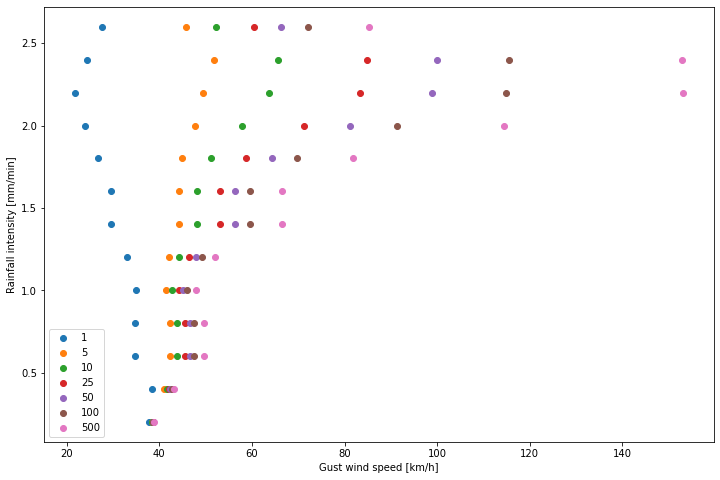

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for rp in intervals:
    plt.scatter(wsrldf[wsrldf.RP==rp].windspeed, wsrldf[wsrldf.RP==rp].rainfall, label=rp)

ax.set_ylabel("Rainfall intensity [mm/min]")
ax.set_xlabel("Gust wind speed [km/h]")
plt.legend()

In [9]:
for wlev in np.arange(1, df.windgust.max()+0.5, 1):
    wdf = df[df.windgust >= wlev]
    rlev = wdf.loc[wdf.groupby(['date'])['rainfall'].idxmax().dropna()]
    if len(rlev) < 20: break
    lmomparam = dict(distr.gpa.lmom_fit(rlev['rainfall'].values))
    rlist.append({
        'stnNum': stnNum,
        'windgust': wlev,
        'max_rainfall': rlev['rainfall'].max(),
        'nobs': len(rlev),
        'shape': lmomparam['c'],
        'loc': lmomparam['loc'],
        'scale': lmomparam['scale']})
    rl = returnLevels(intervals,
                      lmomparam['c'],
                      lmomparam['loc'],
                      lmomparam['scale'], 
                      len(rlev)/(nyears*365.25))
    for val, interval in zip(rl, intervals):
        rprlist.append({
            'stnNum': stnNum,
            'windspeed': wlev,
            'RP': interval,
            'rainfall': val})
rfparamdf = pd.DataFrame(rlist)
rfrldf = pd.DataFrame(rprlist)

In [10]:
rfparamdf

,stnNum,windgust,max_rainfall,nobs,shape,loc,scale
0,32040,1.0,199.0,6750,0.736848,-0.028481,0.094924
1,32040,2.0,199.0,6750,0.736908,-0.028471,0.094868
2,32040,3.0,199.0,6750,0.736908,-0.028471,0.094868
3,32040,4.0,199.0,6750,0.737139,-0.028451,0.094749
4,32040,5.0,199.0,6750,0.737139,-0.028451,0.094749
...,...,...,...,...,...,...,...
72,32040,73.0,3.6,31,-0.008362,-0.125574,1.037402
73,32040,74.0,3.6,31,-0.008362,-0.125574,1.037402
74,32040,75.0,3.6,25,-0.066929,0.038575,1.145269
75,32040,76.0,3.6,25,-0.066929,0.038575,1.145269


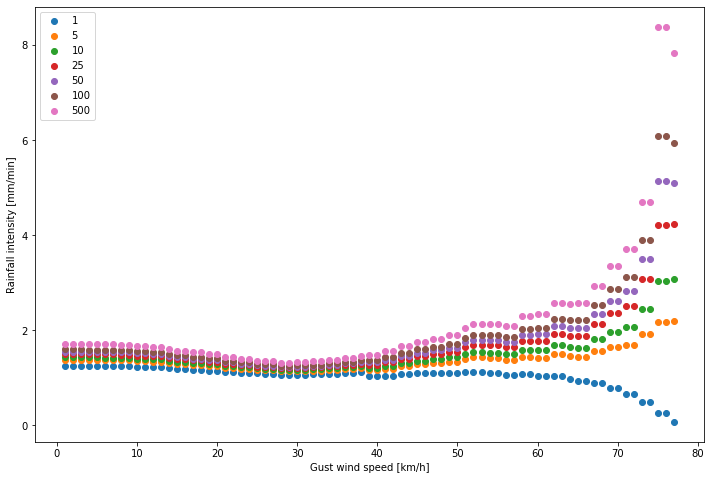

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for rp in intervals:
    plt.scatter(rfrldf[rfrldf.RP==rp].windspeed, rfrldf[rfrldf.RP==rp].rainfall, label=rp)
    
ax.set_ylabel("Rainfall intensity [mm/min]")
ax.set_xlabel("Gust wind speed [km/h]")
plt.legend()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for rp in intervals:
    plt.scatter(rfrldf[rfrldf.RP==rp].windspeed, rfrldf[rfrldf.RP==rp].rainfall, marker='^')
    plt.scatter(wsrldf[wsrldf.RP==rp].windspeed, wsrldf[wsrldf.RP==rp].rainfall, marker='o')
ax.set_ylabel("Rainfall intensity [mm/min]")
ax.set_xlabel("Gust wind speed [km/h]")
#ax.set_yscale('log')
ax.set_xlim((0, 100))
plt.legend()

In [ ]:
rfrldf[rfrldf.RP==1].rainfall